### Problem Statement:

You woke up today with a smile on your face, ready to take on the day. You have all these things to get done, and are thankful that you own a car in the city so you don't have to rely on the schedule of public transportation. You arrive at your car to find a little pink slip attached to your windshield; it's a parking ticket. You pull it out and take a look; your heart sinks. We've all been there. Getting a parking ticket is a sure-fire way to bring down your mood, and potentially your bank account balance.  

While there is no guaranteed approach to avoiding a parking ticket, other than not owning a car, we hope to be able to find trends that might decrease your chances of getting a parking ticket or having your fine dismissed if you do get one. Using data from Open Data DC on parking violations issued from july 2017 - july 2019 in DC, we want to develop a classification model that will predict the likelihood of having a ticket being liable or dismissed. We will gridsearch over machine learning algorithms such as KNN, Logistic Regression, and Support Vector Machines to develop the most robust model that optimizes predictive accuracy. We will also perform EDA on the categorical features  in the dataset to try and unearth trends that might reduce the chances of getting a parking ticket.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import fiona

In [2]:
tickets = pd.read_csv('./Data/total.csv')

In [3]:
tickets.head(2)

,objectid,issuing_agency_code,issuing_agency_name,issuing_agency_short,violation_code,violation_proc_desc,location,disposition_type,fine_amount,total_paid,xcoord,ycoord,latitude,longitude,year,month,date,day,hour,minute
0,60327097,80.0,AMTRAK,AMTRK,P170,FAILURE TO DISPLAY CURRENT TAGS,900 2ND ST NE,Dismissed,100.0,0,399661.0,137013.0,38.901,-77.004,2017,9,5,1,11,30
1,60345241,57.0,METRO POLICE,MTP,P039,PARK AT EXPIRED METER,1290 ALBAMA AVE SE,Liable - System,25.0,60,401049.0,130794.0,38.845,-76.988,2017,9,26,1,10,35


#### Location EDA

In [4]:
# splitting location on each word and creating new column
tickets['loc_tokens'] = tickets['location'].str.split()

In [5]:
tickets.head(2)

,objectid,issuing_agency_code,issuing_agency_name,issuing_agency_short,violation_code,violation_proc_desc,location,disposition_type,fine_amount,total_paid,...,ycoord,latitude,longitude,year,month,date,day,hour,minute,loc_tokens
0,60327097,80.0,AMTRAK,AMTRK,P170,FAILURE TO DISPLAY CURRENT TAGS,900 2ND ST NE,Dismissed,100.0,0,...,137013.0,38.901,-77.004,2017,9,5,1,11,30,"[900, 2ND, ST, NE]"
1,60345241,57.0,METRO POLICE,MTP,P039,PARK AT EXPIRED METER,1290 ALBAMA AVE SE,Liable - System,25.0,60,...,130794.0,38.845,-76.988,2017,9,26,1,10,35,"[1290, ALBAMA, AVE, SE]"


##### Creating new columns for each quadrant (NE, NW, SE, SW)

In [6]:
tickets['NE'] = [each.count('NE') for each in tickets['loc_tokens']]

In [7]:
tickets['NE'].value_counts()

0    2323280
1     346519
2          8
Name: NE, dtype: int64

In [8]:
tickets[tickets['NE'] == 2][['location', 'loc_tokens']]

,location,loc_tokens
1016,311 16TH ST NE (REAR) NE,"[311, 16TH, ST, NE, (REAR), NE]"
1325558,5300 BLAINE ST NE / 53RD ST NE,"[5300, BLAINE, ST, NE, /, 53RD, ST, NE]"
1325559,200 53RD ST NE / CLAY ST NE,"[200, 53RD, ST, NE, /, CLAY, ST, NE]"
1325560,200 53RD ST NE / CLAY ST NE,"[200, 53RD, ST, NE, /, CLAY, ST, NE]"
1325561,200 53RD ST NE / CLAY ST NE,"[200, 53RD, ST, NE, /, CLAY, ST, NE]"
2265024,BLOCK 1800 16TH ST NE @OKIE ST NE,"[BLOCK, 1800, 16TH, ST, NE, @OKIE, ST, NE]"
2427248,FRONT 200 ADAMS ST NE NA @3RD ST NE,"[FRONT, 200, ADAMS, ST, NE, NA, @3RD, ST, NE]"
2577702,3600 20TH ST NE / NEWTON ST NE,"[3600, 20TH, ST, NE, /, NEWTON, ST, NE]"


In [9]:
tickets['NE'] = tickets['NE'].map({0:0, 1:1, 2:1}).astype(int)

In [10]:
tickets['NW'] = [each.count('NW') for each in tickets['loc_tokens']]

In [11]:
tickets['NW'].value_counts()

1    1893819
0     775932
2         56
Name: NW, dtype: int64

In [12]:
tickets['NW'] = tickets['NW'].map({0:0, 1:1, 2:1}).astype(int)

In [13]:
tickets['SE'] = [each.count('SE') for each in tickets['loc_tokens']]

In [14]:
tickets['SE'].value_counts()

0    2410722
1     259079
2          6
Name: SE, dtype: int64

In [15]:
tickets['SE'] = tickets['SE'].map({0:0, 1:1, 2:1}).astype(int)

In [16]:
tickets['SW'] = [each.count('SW') for each in tickets['loc_tokens']]

In [17]:
tickets['SW'].value_counts()

0    2509660
1     160147
Name: SW, dtype: int64

In [18]:
pd.set_option('display.max_columns', None)
tickets.head(2)

,objectid,issuing_agency_code,issuing_agency_name,issuing_agency_short,violation_code,violation_proc_desc,location,disposition_type,fine_amount,total_paid,xcoord,ycoord,latitude,longitude,year,month,date,day,hour,minute,loc_tokens,NE,NW,SE,SW
0,60327097,80.0,AMTRAK,AMTRK,P170,FAILURE TO DISPLAY CURRENT TAGS,900 2ND ST NE,Dismissed,100.0,0,399661.0,137013.0,38.901,-77.004,2017,9,5,1,11,30,"[900, 2ND, ST, NE]",1,0,0,0
1,60345241,57.0,METRO POLICE,MTP,P039,PARK AT EXPIRED METER,1290 ALBAMA AVE SE,Liable - System,25.0,60,401049.0,130794.0,38.845,-76.988,2017,9,26,1,10,35,"[1290, ALBAMA, AVE, SE]",0,0,1,0


In [19]:
# Checking to see if any rows are not represented or represented more than once in new quadrant columns
tickets[(tickets['NE']+tickets['NW']+tickets['SE']+tickets['SW']) != 1]

,objectid,issuing_agency_code,issuing_agency_name,issuing_agency_short,violation_code,violation_proc_desc,location,disposition_type,fine_amount,total_paid,xcoord,ycoord,latitude,longitude,year,month,date,day,hour,minute,loc_tokens,NE,NW,SE,SW
47,60588374,77.0,D.C. HOUSING AUTHORITY,DCHA,P344,VEHICLE ON PRIVATE/PUBLIC PROPERTY WITHOUT CON...,221 37TH PL,Other,250.0,500,404176.0,135410.0,38.887,-76.952,2017,9,12,1,8,51,"[221, 37TH, PL]",0,0,0,0
59,60622224,7.0,METROPOLITAN POLICE DPT-DISTRICT 7,MPD-7D,P344,VEHICLE ON PRIVATE/PUBLIC PROPERTY WITHOUT CON...,832 BARNABY ST,Liable - System,250.0,0,400658.0,129293.0,38.831,-76.992,2017,9,27,2,11,35,"[832, BARNABY, ST]",0,0,0,0
135,60683719,6.0,METROPOLITAN POLICE DPT-DISTRICT 6,MPD-6D,P013,PARK WITHIN 5 FEET OF DRIVEWAY OR ALLEY,4900 AYERS PL,Liable - System,20.0,0,405900.0,135701.0,38.889,-76.932,2017,9,10,6,4,0,"[4900, AYERS, PL]",0,0,0,0
566,60740730,21.0,MPD RESERVE CORPS,MPD-RC,P043,PARK TO REDUCE ROADWAY TO LESS THAN 10 FEET,9 LOGAN CIRCLE,Dismissed,25.0,0,397365.0,138033.0,38.910,-77.030,2017,9,24,6,9,15,"[9, LOGAN, CIRCLE]",0,0,0,0
793,60745581,2.0,METROPOLITAN POLICE DPT-DISTRICT 2,MPD-2D,P010,OBSTRUCTING CROSSWALK,5171 MAC ARTHUR BLVD,Other,50.0,50,391108.0,139849.0,38.926,-77.103,2017,9,19,1,11,23,"[5171, MAC, ARTHUR, BLVD]",0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667094,77042351,15.0,DEPARTMENT OF PUBLIC WORKS,DPW,P002,STAND OR PARK IN ALLEY,REAR OF 1400 BLOCK CLIFTON ST NW*,Other,30.0,30,397324.0,139396.0,38.922,-77.031,2019,2,28,3,23,24,"[REAR, OF, 1400, BLOCK, CLIFTON, ST, NW*]",0,0,0,0
2667574,77048181,15.0,DEPARTMENT OF PUBLIC WORKS,DPW,P002,STAND OR PARK IN ALLEY,REAR OF 1400 BLOCK CLIFTON ST NW*,Liable - System,30.0,0,397324.0,139396.0,38.922,-77.031,2019,2,25,0,2,38,"[REAR, OF, 1400, BLOCK, CLIFTON, ST, NW*]",0,0,0,0
2668160,77055206,15.0,DEPARTMENT OF PUBLIC WORKS,DPW,P002,STAND OR PARK IN ALLEY,REAR OF 1400 BLOCK CLIFTON ST NW*,Other,30.0,30,397324.0,139396.0,38.922,-77.031,2019,2,23,5,0,4,"[REAR, OF, 1400, BLOCK, CLIFTON, ST, NW*]",0,0,0,0
2668769,77062030,15.0,DEPARTMENT OF PUBLIC WORKS,DPW,P344,VEHICLE ON PRIVATE/PUBLIC PROPERTY WITHOUT CON...,IN GARAGE OF 2323 SHERMAN AVE NW*,Other,250.0,0,397838.0,139245.0,38.921,-77.025,2019,2,27,2,9,33,"[IN, GARAGE, OF, 2323, SHERMAN, AVE, NW*]",0,0,0,0


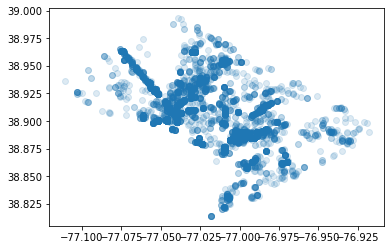

In [20]:
# Visualizing tickets with no quadrant data for any discernable trends
plt.scatter(x=tickets[(tickets['NE']+tickets['NW']+tickets['SE']+tickets['SW']) != 1][['longitude',]],
           y=tickets[(tickets['NE']+tickets['NW']+tickets['SE']+tickets['SW']) != 1][['latitude',]], alpha=.15);

In [21]:
# Dropping all rows in which there is no quadrant identifier - 10,174 rows
tickets.drop(tickets[(tickets['NE']+tickets['NW']+tickets['SE']+tickets['SW']) != 1].index, inplace=True)

In [22]:
# Dropping rows which have more than one quadrant identifier - 1 row
tickets.drop(tickets[(tickets['NE']+tickets['NW']+tickets['SE']+tickets['SW']) == 2].index, inplace=True)

##### Diposition_type distributions

In [23]:
tickets['disposition_type'].value_counts()

Other               1761357
Liable - System      594062
Dismissed            160858
Liable               138160
Void                   2874
Continued              1483
Administrative          719
Liable - Traffic        119
Name: disposition_type, dtype: int64

##### Without a proper data dictionary, it is difficult to decipher what some of the classes in the disposition_type column mean. A request was made out to the open data dc offices for a data dictionary on this dataset; however, based on responses it doesn't seem they will be able to get one to us in time to complete this project by the due date.  

##### Therefore, we will attempt to perform some empirical analysis on the dispostion_type category to see if we can spot some trends that will help us in identifying the different classes such as 'other', 'void', 'continued', and 'administrative' in this dataset.  

##### If unsuccessful, we will be dropping all rows containing 'other', 'void', 'continued', and 'administrative' as their disposition_type, and grouping together the 'liable', 'liable_system', and 'liable - traffic' into one 'liable' class. We should then be left with only two classes in the dispostion_type column: 'liable' and 'dismissed'.

##### We understand that dropping a large amount of data from our dataset like this is likely to introduce some bias into our model that may affect the accuracy of any predicitons or inferences made from our model. However, given the scope and time constraints of this project, we feel it is necessary.

In [24]:
tickets[tickets['disposition_type'] == 'Continued'][['disposition_type','total_paid', 'fine_amount']]

,disposition_type,total_paid,fine_amount
3607,Continued,250,250.0
4697,Continued,50,50.0
16771,Continued,0,100.0
20043,Continued,100,100.0
21072,Continued,50,50.0
...,...,...,...
2662140,Continued,0,100.0
2663383,Continued,100,100.0
2665035,Continued,0,50.0
2666869,Continued,0,100.0


In [25]:
# 1,761,357 rows with disposition_type = 'other'
tickets[tickets['disposition_type'] == 'Other'][['disposition_type','total_paid', 'fine_amount']]

,disposition_type,total_paid,fine_amount
4,Other,25,25.0
5,Other,25,25.0
6,Other,25,25.0
10,Other,50,25.0
11,Other,30,30.0
...,...,...,...
2669799,Other,0,50.0
2669800,Other,0,100.0
2669801,Other,0,50.0
2669802,Other,25,25.0


In [26]:
# number of tix with disposition type 'other' whose total_paid amount is $0 - 322,301 rows
# we can infer that maybe due to some user/system error, these were 'dismissed' but not input as such
tickets[(tickets['disposition_type'] == 'Other')
             & (tickets['total_paid'] == 0) ][['disposition_type','total_paid', 'fine_amount']]

,disposition_type,total_paid,fine_amount
376,Other,0,25.0
377,Other,0,50.0
378,Other,0,100.0
625,Other,0,250.0
731,Other,0,100.0
...,...,...,...
2669796,Other,0,50.0
2669797,Other,0,50.0
2669799,Other,0,50.0
2669800,Other,0,100.0


In [27]:
# number of tix with disposition type 'other' that have 
# paid less than the total fine_amount but more than $0 - 394 rows
# we can infer that maybe due to some user/system error, these were 'liable' but not input as such
# and probably had some late penalty fines tacked on to their original fine
tickets[(tickets['disposition_type'] == 'Other')
             & (tickets['total_paid'] < tickets['fine_amount'])
             & (tickets['total_paid'] != 0)][['disposition_type','total_paid', 'fine_amount']]

,disposition_type,total_paid,fine_amount
1018,Other,5,65.0
3745,Other,231,250.0
5623,Other,42,100.0
12012,Other,78,100.0
32188,Other,50,100.0
...,...,...,...
2647167,Other,20,100.0
2648642,Other,50,100.0
2655522,Other,25,50.0
2660280,Other,60,100.0


In [28]:
# number of tix with disposition type 'other' that have paid the exact total fine_amount  - 1,209,583 rows
# we can infer that maybe due to some user/system error, these were 'liable' but not input as such
tickets[(tickets['disposition_type'] == 'Other')
             & (tickets['total_paid'] == tickets['fine_amount'])
             & (tickets['total_paid'] != 0)][['disposition_type','total_paid', 'fine_amount']]

,disposition_type,total_paid,fine_amount
4,Other,25,25.0
5,Other,25,25.0
6,Other,25,25.0
11,Other,30,30.0
13,Other,30,30.0
...,...,...,...
2669785,Other,50,50.0
2669786,Other,50,50.0
2669798,Other,30,30.0
2669802,Other,25,25.0


In [29]:
# number of tix with disposition type 'other' that have
# paid more than the total fine_amount but more than $0 - 229,079 rows
# we can infer that maybe due to some user/system error, these were 'liable' but not input as such
# and probably paid extra for late penalty fines
tickets[(tickets['disposition_type'] == 'Other')
             & (tickets['total_paid'] > tickets['fine_amount'])
             & (tickets['total_paid'] != 0)][['disposition_type','total_paid', 'fine_amount']]

,disposition_type,total_paid,fine_amount
10,Other,50,25.0
17,Other,60,30.0
24,Other,500,250.0
38,Other,200,100.0
53,Other,60,30.0
...,...,...,...
2669784,Other,100,50.0
2669787,Other,200,100.0
2669790,Other,60,30.0
2669793,Other,40,20.0


In [30]:
# number of tix that were 'dismissed' and paid $0 in fines - 158,637 rows
# this is less than the 160,858 total number of 'dismissed' rows
# this must mean some tickets that were 'dismissed' actually made a fine payment
tickets[(tickets['disposition_type'] == 'Dismissed')
             & (tickets['total_paid'] == 0)][['disposition_type','total_paid', 'fine_amount']]

,disposition_type,total_paid,fine_amount
0,Dismissed,0,100.0
16,Dismissed,0,30.0
20,Dismissed,0,25.0
21,Dismissed,0,250.0
22,Dismissed,0,250.0
...,...,...,...
2669705,Dismissed,0,25.0
2669791,Dismissed,0,30.0
2669804,Dismissed,0,250.0
2669805,Dismissed,0,20.0


In [31]:
# number of tix that were dismissed but still made a payment toward fine amount - 2891 rows
tickets[(tickets['disposition_type'] == 'Dismissed')
            & (tickets['total_paid'] != 0)][['disposition_type',
                                                        'total_paid',
                                                        'fine_amount']].sort_values(by='total_paid', ascending=False)

,disposition_type,total_paid,fine_amount
1539057,Dismissed,1000,1000.0
1910772,Dismissed,500,500.0
2302078,Dismissed,300,150.0
2180670,Dismissed,250,250.0
322083,Dismissed,250,250.0
...,...,...,...
2265186,Dismissed,5,5.0
2265046,Dismissed,5,5.0
2579050,Dismissed,5,5.0
2435512,Dismissed,5,5.0


2891 + 157,967 = 160,858 (total number 'dismissed')

In [32]:
# Dropping rows with disposition_type = 'other'
tickets.drop(tickets[tickets['disposition_type'] == 'Other'].index, inplace=True)

# Dropping rows with disposition_type = 'void'
tickets.drop(tickets[tickets['disposition_type'] == 'Void'].index, inplace=True)

# Dropping rows with disposition_type = 'continued'
tickets.drop(tickets[tickets['disposition_type'] == 'Continued'].index, inplace=True)

# Dropping rows with disposition_type = 'administrative'
tickets.drop(tickets[tickets['disposition_type'] == 'Administrative'].index, inplace=True)

In [33]:
# Unnecessary columns to drop -'issuing agency code', 'xcoord', 'ycoord', 'location'

tickets.drop(columns=['issuing_agency_code', 'xcoord', 'ycoord', 'location'], inplace=True)

In [34]:
tickets.head(1)

,objectid,issuing_agency_name,issuing_agency_short,violation_code,violation_proc_desc,disposition_type,fine_amount,total_paid,latitude,longitude,year,month,date,day,hour,minute,loc_tokens,NE,NW,SE,SW
0,60327097,AMTRAK,AMTRK,P170,FAILURE TO DISPLAY CURRENT TAGS,Dismissed,100.0,0,38.901,-77.004,2017,9,5,1,11,30,"[900, 2ND, ST, NE]",1,0,0,0


In [35]:
tickets['disposition_type'].value_counts()

Liable - System     594062
Dismissed           160858
Liable              138160
Liable - Traffic       119
Name: disposition_type, dtype: int64

In [36]:
# Grouping all the different type of liables into one 'liable' class
tickets['disposition_type'] = tickets['disposition_type'].replace(
    ['Liable - System','Liable - Traffic'], 'Liable')

In [37]:
tickets['disposition_type'].value_counts()

Liable       732341
Dismissed    160858
Name: disposition_type, dtype: int64

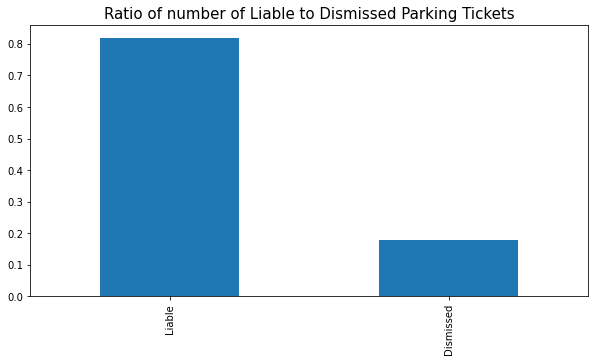

In [38]:
plt.figure(figsize=(10,5))
(tickets['disposition_type'].value_counts(normalize=True)).plot(kind='bar')
plt.title('Ratio of number of Liable to Dismissed Parking Tickets', size=15);

plt.savefig('Images/liable_vs_dismissed.png')

only about 18% of tickets get dismissed, or about 1 in 5

In [39]:
tickets.shape

(893199, 21)

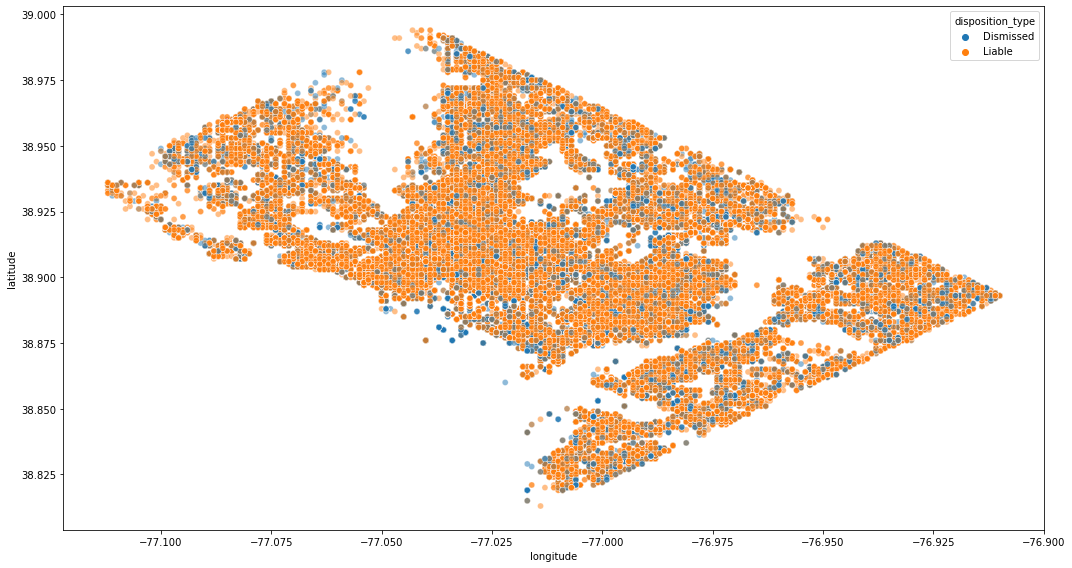

In [40]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot(data=tickets,
                x = 'longitude',
                y = 'latitude',
                hue = 'disposition_type',
#                 palette = 'copper_r',
                alpha = 0.5)
plt.tight_layout()

plt.savefig('Images/disposition_spread.png')

In [41]:
# Create new column 'quadrants' that contains quadrant names
# by kinda 'reverse one-hot encoding' the individual quadrant columns using .idxmax()
# source: https://stackoverflow.com/questions/38334296/reversing-one-hot-encoding-in-pandas
tickets['quadrant'] = tickets[['NE','NW','SE','SW']].idxmax(1)
tickets.head(1)

,objectid,issuing_agency_name,issuing_agency_short,violation_code,violation_proc_desc,disposition_type,fine_amount,total_paid,latitude,longitude,year,month,date,day,hour,minute,loc_tokens,NE,NW,SE,SW,quadrant
0,60327097,AMTRAK,AMTRK,P170,FAILURE TO DISPLAY CURRENT TAGS,Dismissed,100.0,0,38.901,-77.004,2017,9,5,1,11,30,"[900, 2ND, ST, NE]",1,0,0,0,NE


##### SAVING CLEAN TICKETS DATASET

In [42]:
# tickets.to_csv('Data/clean_tickets_dc.csv', index=False)

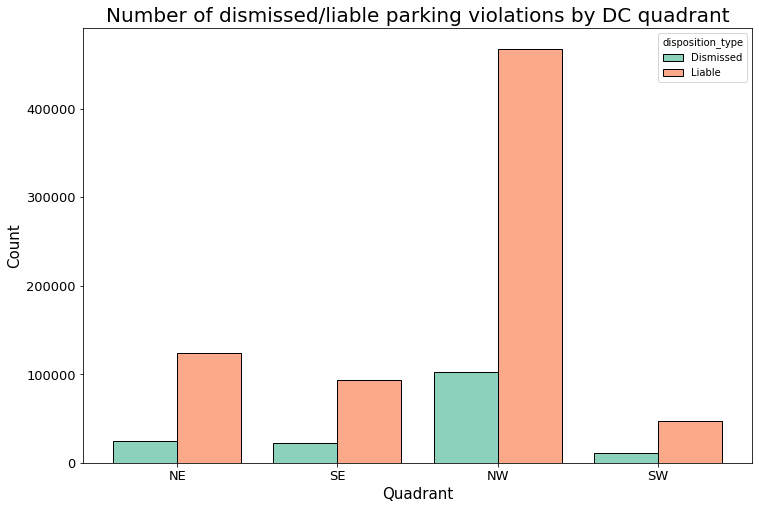

In [43]:

plt.figure(figsize=(12,8))
sns.histplot(data=tickets, x='quadrant', hue='disposition_type', multiple='dodge', shrink=.8, palette='Set2')
plt.title('Number of dismissed/liable parking violations by DC quadrant', size=20)
plt.xticks(size=13)
plt.yticks(size=13)
plt.ylabel('Count', size=15)
plt.xlabel('Quadrant', size=15);

plt.savefig('Images/quadrant_dismissed_vs_liable.png')

In [44]:
tickets.groupby(by='quadrant').count()

,objectid,issuing_agency_name,issuing_agency_short,violation_code,violation_proc_desc,disposition_type,fine_amount,total_paid,latitude,longitude,year,month,date,day,hour,minute,loc_tokens,NE,NW,SE,SW
quadrant,,,,,,,,,,,,,,,,,,,,,
NE,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695,148695
NW,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634,570634
SE,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484,115484
SW,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386,58386


In [45]:
tickets.describe()

,objectid,fine_amount,total_paid,latitude,longitude,year,month,date,day,hour,minute,NE,NW,SE,SW
count,8.931990e+05,893199.000000,893199.000000,893199.000000,893199.000000,893199.000000,893199.000000,893199.000000,893199.000000,893199.000000,893199.000000,893199.000000,893199.000000,893199.000000,893199.000000
mean,6.013750e+07,64.371473,31.711566,38.904152,-77.019228,2017.776519,6.980590,15.610792,2.467660,12.123266,28.658728,0.166475,0.638865,0.129293,0.065367
std,2.658006e+07,50.841189,63.448827,0.023237,0.029029,0.577766,3.420861,8.773353,1.630439,6.028199,17.322502,0.372506,0.480330,0.335524,0.247173
min,2.764460e+05,1.000000,0.000000,38.813000,-77.112000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.077900e+07,30.000000,0.000000,38.894000,-77.036000,2017.000000,4.000000,8.000000,1.000000,9.000000,14.000000,0.000000,0.000000,0.000000,0.000000
50%,7.551375e+07,50.000000,0.000000,38.903000,-77.023000,2018.000000,8.000000,15.000000,2.000000,12.000000,28.000000,0.000000,1.000000,0.000000,0.000000
75%,7.610649e+07,100.000000,50.000000,38.915000,-77.003000,2018.000000,10.000000,23.000000,4.000000,16.000000,44.000000,0.000000,1.000000,0.000000,0.000000
max,7.752025e+07,5000.000000,2400.000000,38.994000,-76.910000,2019.000000,12.000000,31.000000,6.000000,23.000000,59.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
tickets.groupby(by='quadrant')['disposition_type'].value_counts()

quadrant  disposition_type
NE        Liable              123969
          Dismissed            24726
NW        Liable              467843
          Dismissed           102791
SE        Liable               93579
          Dismissed            21905
SW        Liable               46950
          Dismissed            11436
Name: disposition_type, dtype: int64

In [47]:
tickets.groupby(by='quadrant')['disposition_type'].value_counts(normalize=True).to_frame()


disposition_type
quadrant disposition_type                  
NE       Liable                    0.833713
         Dismissed                 0.166287
NW       Liable                    0.819865
         Dismissed                 0.180135
SE       Liable                    0.810320
         Dismissed                 0.189680
SW       Liable                    0.804131
         Dismissed                 0.195869

Proportion of liable to dismissed parking citations per quadrant is pretty even. No significant differences.

In [48]:
# tickets[tickets['violation_code'] == 'P100'][['fine_amount']]


In [49]:
# pd.set_option('display.max_rows', None)
# tickets[['violation_proc_desc', 'violation_code']].value_counts(ascending=False)

In [50]:
tickets.groupby('issuing_agency_name')['disposition_type'].value_counts(normalize=True).to_frame()
# [citations_df[citations_df['disposition_type'] == 'Dismissed']]

disposition_type
issuing_agency_name                 disposition_type                  
AMTRAK                              Dismissed                 0.882353
                                    Liable                    0.117647
BOLLING AFB                         Liable                    0.567742
                                    Dismissed                 0.432258
COMMAND INFORMATION CENTER          Liable                    0.517426
...                                                                ...
US. GOVERNMENT PRINTING OFFICE      Liable                    0.409091
US. SECRET SERVICE UNIFORM DIVISION Dismissed                 0.500000
                                    Liable                    0.500000
YOUTH DIVISION                      Dismissed                 0.555556
                                    Liable                    0.444444

[93 rows x 1 columns]

##### Baseline Accuracy

In [51]:
tickets['disposition_type'].value_counts(normalize=True)

Liable       0.819908
Dismissed    0.180092
Name: disposition_type, dtype: float64

#### Agencies EDA

In [52]:
tickets.loc[tickets['issuing_agency_name']=='U.S. NATIONAL ZOOLOGICAL POLICE']['violation_proc_desc'].value_counts()

NO PARKING ANYTIME                                   6
DISOBEYING OFFICIAL SIGN                             4
PARK IN A BUS ZONE                                   2
PARK WITHIN 10 FEET OF A FIRE HYDRANT                2
PARK ON SIDEWALK OR AREA RESERVED FOR PEDESTRIANS    1
DEPOSIT PAYMENT TO EXTEND TIME BEYOND METER LIMIT    1
NO STANDING ANYTIME                                  1
UNAUTHORIZED VEHICLE IN LOADING ZONE                 1
FAILURE TO DISPLAY CURRENT TAGS                      1
Name: violation_proc_desc, dtype: int64

In [53]:
tickets['issuing_agency_name'].value_counts().head(20)

DEPARTMENT OF PUBLIC WORKS             826629
METROPOLITAN POLICE DPT-DISTRICT 2      11009
METROPOLITAN POLICE DPT-DISTRICT 1       7337
METROPOLITAN POLICE DPT-DISTRICT 3       6430
METROPOLITAN POLICE DPT-DISTRICT 4       5939
METROPOLITAN POLICE DPT-DISTRICT 7       5003
METRO POLICE                             4808
DDOT                                     4379
METROPOLITAN POLICE DPT-DISTRICT 5       3980
METROPOLITAN POLICE DPT-DISTRICT 6       3478
D.C. HOUSING AUTHORITY                   3259
UNITED STATES PARK POLICE                2714
SPECIAL OPERATION DIV & TRAFFIC DIV      1848
UNITED STATES CAPITOL POLICE             1397
PROTECTIVE SERVICES DEPT (DC GOVT)       1135
US. SECRET SERVICE UNIFORM DIVISION       758
UNVRSTY OF THE D.C. SECURITY POLICE       406
FEDERAL PROTECTIVE SERVICES (US GV)       393
COMMAND INFORMATION CENTER                373
DPT. OF GENERAL SERVICES GUARDS           266
Name: issuing_agency_name, dtype: int64

In [54]:
tickets['issuing_agency_name'].value_counts().head(15)

DEPARTMENT OF PUBLIC WORKS             826629
METROPOLITAN POLICE DPT-DISTRICT 2      11009
METROPOLITAN POLICE DPT-DISTRICT 1       7337
METROPOLITAN POLICE DPT-DISTRICT 3       6430
METROPOLITAN POLICE DPT-DISTRICT 4       5939
METROPOLITAN POLICE DPT-DISTRICT 7       5003
METRO POLICE                             4808
DDOT                                     4379
METROPOLITAN POLICE DPT-DISTRICT 5       3980
METROPOLITAN POLICE DPT-DISTRICT 6       3478
D.C. HOUSING AUTHORITY                   3259
UNITED STATES PARK POLICE                2714
SPECIAL OPERATION DIV & TRAFFIC DIV      1848
UNITED STATES CAPITOL POLICE             1397
PROTECTIVE SERVICES DEPT (DC GOVT)       1135
Name: issuing_agency_name, dtype: int64

In [55]:
top_15_dismiss = tickets.groupby(by='issuing_agency_name')['disposition_type'].value_counts(normalize=True)[[9,11,13,31,36,38,40,42,44,46,48,62,68,78,79]]

In [56]:
pd.DataFrame(top_15_dismiss.sort_values()).index[range(15)]

MultiIndex([(       'UNITED STATES CAPITOL POLICE', 'Dismissed'),
            (         'DEPARTMENT OF PUBLIC WORKS', 'Dismissed'),
            ( 'METROPOLITAN POLICE DPT-DISTRICT 7', 'Dismissed'),
            ( 'METROPOLITAN POLICE DPT-DISTRICT 6', 'Dismissed'),
            ( 'METROPOLITAN POLICE DPT-DISTRICT 2', 'Dismissed'),
            (                               'DDOT', 'Dismissed'),
            (             'D.C. HOUSING AUTHORITY', 'Dismissed'),
            ( 'METROPOLITAN POLICE DPT-DISTRICT 3', 'Dismissed'),
            ( 'METROPOLITAN POLICE DPT-DISTRICT 5', 'Dismissed'),
            ( 'METROPOLITAN POLICE DPT-DISTRICT 4', 'Dismissed'),
            ('SPECIAL OPERATION DIV & TRAFFIC DIV', 'Dismissed'),
            ( 'METROPOLITAN POLICE DPT-DISTRICT 1', 'Dismissed'),
            (                       'METRO POLICE', 'Dismissed'),
            ( 'PROTECTIVE SERVICES DEPT (DC GOVT)', 'Dismissed'),
            (          'UNITED STATES PARK POLICE', 'Dismissed')],
         

In [62]:
new_frame = pd.DataFrame()

In [63]:
new_frame['issuing_agency_name'] = ['UNITED STATES CAPITOL POLICE','DEPARTMENT OF PUBLIC WORKS','METROPOLITAN POLICE DPT-DISTRICT 7','METROPOLITAN POLICE DPT-DISTRICT 6','METROPOLITAN DISTRICT 2','DDOT','D.C. HOUSING AUTHORITY','METROPOLITAN POLICE DPT-DISTRICT 3','METROPOLITAN POLICE DPT-DISTRICT 5','METROPOLITAN POLICE DPT-DISTRICT 4','SPECIAL OPERATION DIV & TRAFFIC DIV','METROPOLITAN POLICE DPT-DISTRICT 1','METRO POLICE','PROTECTIVE SERVICES DEPT (DC GOVT)', 'UNITED STATES PARK POLICE']

In [64]:
top_15_dismiss.sort_values()

issuing_agency_name                  disposition_type
UNITED STATES CAPITOL POLICE         Dismissed           0.161775
DEPARTMENT OF PUBLIC WORKS           Dismissed           0.163938
METROPOLITAN POLICE DPT-DISTRICT 7   Dismissed           0.252648
METROPOLITAN POLICE DPT-DISTRICT 6   Dismissed           0.257619
METROPOLITAN POLICE DPT-DISTRICT 2   Dismissed           0.278136
DDOT                                 Dismissed           0.330669
D.C. HOUSING AUTHORITY               Dismissed           0.341516
METROPOLITAN POLICE DPT-DISTRICT 3   Dismissed           0.354121
METROPOLITAN POLICE DPT-DISTRICT 5   Dismissed           0.369095
METROPOLITAN POLICE DPT-DISTRICT 4   Dismissed           0.399057
SPECIAL OPERATION DIV & TRAFFIC DIV  Dismissed           0.406385
METROPOLITAN POLICE DPT-DISTRICT 1   Dismissed           0.407660
METRO POLICE                         Dismissed           0.589434
PROTECTIVE SERVICES DEPT (DC GOVT)   Dismissed           0.630837
UNITED STATES PARK POL

In [65]:
new_frame['dismissal rate'] = [.16166,.163935,.252953,0.258295,0.278457,0.330524,0.341538,0.354509,0.368553,0.399967,0.406587,0.409411,0.589526,0.630282,0.681634]

In [66]:
strict_agencies = new_frame.head(5)

In [100]:
lenient_agencies = new_frame.tail(3)

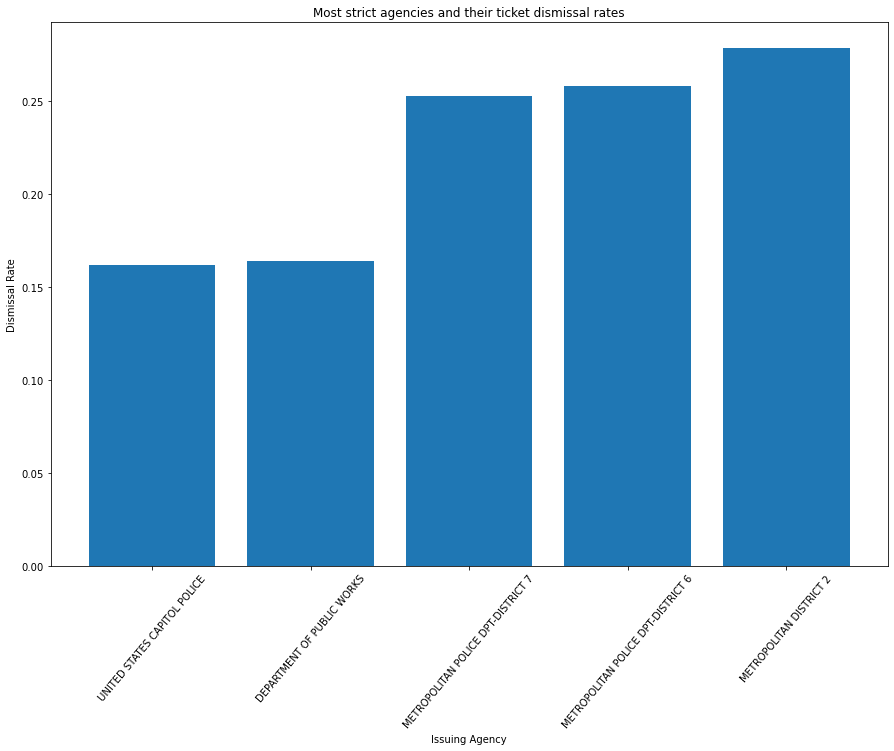

In [68]:
# Size
plt.figure(figsize = (15, 10))

# Bar chart
plt.bar(strict_agencies['issuing_agency_name'],
        strict_agencies['dismissal rate'])

# Create a descriptive title
plt.title('Most strict agencies and their ticket dismissal rates')
# Rotate text
plt.xticks(rotation = 50)
# Add axis labels
plt.xlabel('Issuing Agency')
plt.ylabel('Dismissal Rate'); # semicolon suppresses text output

plt.savefig('Images/Strict.png')

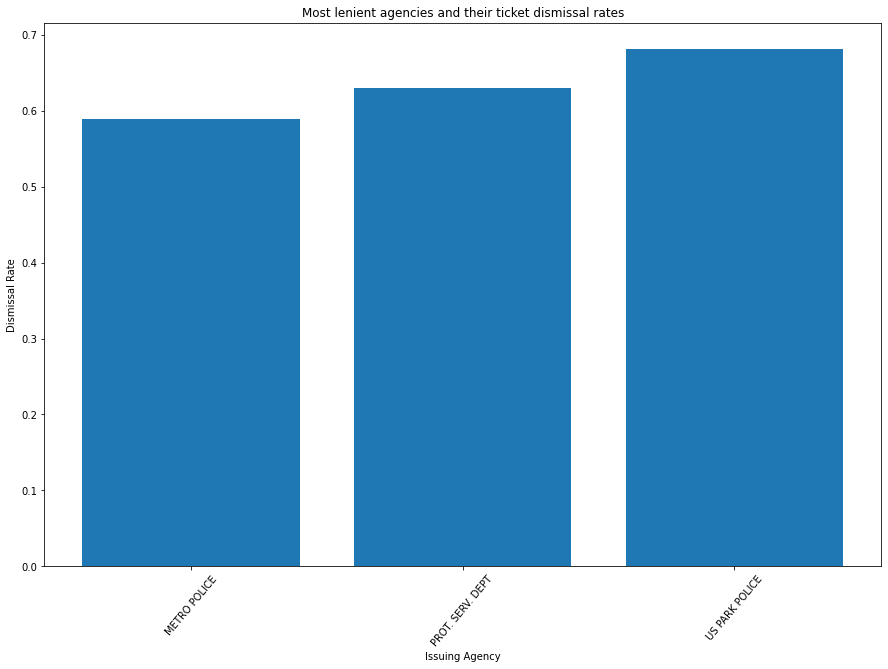

In [101]:
# Size
plt.figure(figsize = (15, 10))

# Bar chart
plt.bar(lenient_agencies['issuing_agency_name'],
        lenient_agencies['dismissal rate'])

# Create a descriptive title
plt.title('Most lenient agencies and their ticket dismissal rates')
# Rotate text
plt.xticks(rotation = 50)
# Add axis labels
plt.xlabel('Issuing Agency')
plt.ylabel('Dismissal Rate'); # semicolon suppresses text output

plt.savefig('Images/Lenient.png')

In [69]:
new_frame['issuing_agency_name'] = ['US CAPITOL POLICE','DEP. PUBLIC WORKS','METROPOL DIST 7','METROPOL DIST 6','METROPOL DIST 2','DDOT','D.C. HOUS. AUTHOR.','METROPOL DIST 3','METROPOL DIST 5','METROPOL DIST 4','SPECOPS DIV','METROPOL DIST 1','METRO POLICE','PROT. SERV. DEPT','US PARK POLICE']

In [70]:
# new_frame

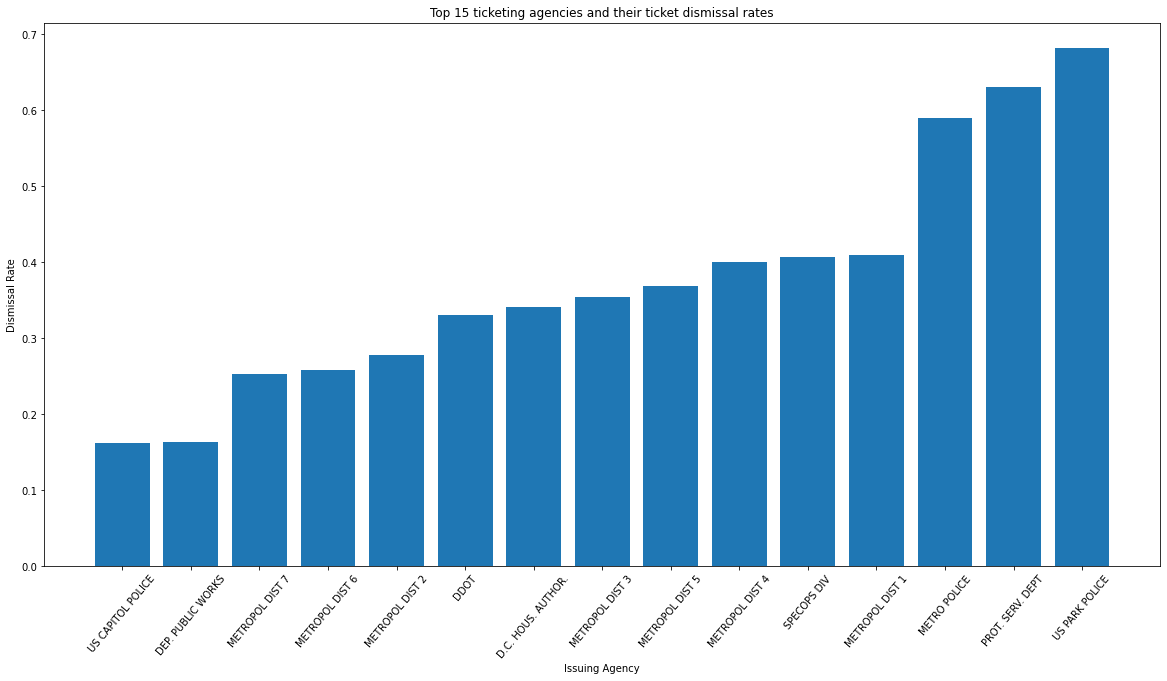

In [71]:
# Size
plt.figure(figsize = (20, 10))

# Bar chart
plt.bar(new_frame['issuing_agency_name'],
        new_frame['dismissal rate'])

# Create a descriptive title
plt.title('Top 15 ticketing agencies and their ticket dismissal rates')
# Rotate text
plt.xticks(rotation = 50)
# Add axis labels
plt.xlabel('Issuing Agency')
plt.ylabel('Dismissal Rate'); # semicolon suppresses text output

plt.savefig('Images/Top_15.png')

In [72]:
full_dismissed = tickets.groupby(by='issuing_agency_name')['disposition_type'].value_counts(normalize=True)[[0,3,5,6,9,11,13,14,17,20,23,24,26,28,30,31,33,36,38,40,42,44,46,48,50,52,55,58,61,62,66,68,70,71,74,75,78,79,81,83,86,87,89,91]]

In [73]:
len(full_dismissed)

44

In [74]:
2530465/len(tickets['issuing_agency_name'])

2.8330360871429545

In [75]:
tickets['issuing_agency_name'].value_counts()

DEPARTMENT OF PUBLIC WORKS             826629
METROPOLITAN POLICE DPT-DISTRICT 2      11009
METROPOLITAN POLICE DPT-DISTRICT 1       7337
METROPOLITAN POLICE DPT-DISTRICT 3       6430
METROPOLITAN POLICE DPT-DISTRICT 4       5939
METROPOLITAN POLICE DPT-DISTRICT 7       5003
METRO POLICE                             4808
DDOT                                     4379
METROPOLITAN POLICE DPT-DISTRICT 5       3980
METROPOLITAN POLICE DPT-DISTRICT 6       3478
D.C. HOUSING AUTHORITY                   3259
UNITED STATES PARK POLICE                2714
SPECIAL OPERATION DIV & TRAFFIC DIV      1848
UNITED STATES CAPITOL POLICE             1397
PROTECTIVE SERVICES DEPT (DC GOVT)       1135
US. SECRET SERVICE UNIFORM DIVISION       758
UNVRSTY OF THE D.C. SECURITY POLICE       406
FEDERAL PROTECTIVE SERVICES (US GV)       393
COMMAND INFORMATION CENTER                373
DPT. OF GENERAL SERVICES GUARDS           266
YOUTH DIVISION                            261
FBI                               

In [76]:
tickets.loc[tickets['issuing_agency_name']=='OFFICE OF PROFESSIONAL RESPONSIBLTY']['violation_proc_desc'].value_counts()

FAILURE TO DISPLAY CURRENT TAGS                       13
PARK IN OFFICIAL PARKING PERMIT ONLY SPACE            12
NO PARKING ANYTIME                                    10
NO STANDING ANYTIME                                    9
VEHICLE ON PRIVATE/PUBLIC PROPERTY WITHOUT CONSENT     8
OBSTRUCTING CROSSWALK                                  5
INDIVID W/ DISABILITIES ONLY UNAUTH. USE RSRVD SP      4
DISOBEYING OFFICIAL SIGN                               3
PARK IN A FIRE LANE                                    2
PARK OVERTIME IN TIMED ZONE                            2
FAIL TO DISPLAY CURRENT INSPECTION STICKER             2
OBSTRUCTING ENTRANCE OF PKG GARAGE, DOOR OR GATE       1
EXPIRED INSPECTION REJECTION STICKER                   1
NO PARKING SPECIFIC HOURS                              1
Name: violation_proc_desc, dtype: int64

In [77]:
tickets.loc[tickets['issuing_agency_name']=='YOUTH DIVISION']['violation_proc_desc'].value_counts()

STOPPING, STANDING OR PARKING VEHICLE IN BIKE LANE    131
NO PARKING ANYTIME                                     37
RESIDENTIAL PERMIT PKING BEYOND LIMIT W/O PERMIT       29
PARK AT EXPIRED METER                                  25
PARKED LESS THAN 3 FEET FROM ANOTHER VEHICLE            6
PARK ABREAST OF ANOTHER VEHICLE                         5
VEHICLE ON PRIVATE/PUBLIC PROPERTY WITHOUT CONSENT      5
OBSTRUCTING CROSSWALK                                   5
UNAUTHORIZED VEHICLE IN LOADING ZONE                    4
FAILURE TO DISPLAY CURRENT TAGS                         3
PARK MORE THAN 12 INCHES FROM CURB                      2
STREETCAR-PARK, STOP  STAND VEH  GUIDEWAY/PLATFORM      2
NO STANDING ANYTIME                                     2
RESIDENTIAL PMT PKG 3RD OFFENSE CALENDAR YEAR           1
NO FRONT TAGS.                                          1
METER, FAIL TO DEPOSIT PAYMENT                          1
OBSTRUCTING ENTRANCE OF PKG GARAGE, DOOR OR GATE        1
INDIVID W/ DIS

In [78]:
tickets.loc[tickets['issuing_agency_name']=='U.S. NATIONAL ZOOLOGICAL POLICE']['violation_proc_desc'].value_counts()

NO PARKING ANYTIME                                   6
DISOBEYING OFFICIAL SIGN                             4
PARK IN A BUS ZONE                                   2
PARK WITHIN 10 FEET OF A FIRE HYDRANT                2
PARK ON SIDEWALK OR AREA RESERVED FOR PEDESTRIANS    1
DEPOSIT PAYMENT TO EXTEND TIME BEYOND METER LIMIT    1
NO STANDING ANYTIME                                  1
UNAUTHORIZED VEHICLE IN LOADING ZONE                 1
FAILURE TO DISPLAY CURRENT TAGS                      1
Name: violation_proc_desc, dtype: int64

In [98]:
tickets.loc[tickets['issuing_agency_name']=='DEPARTMENT OF PUBLIC WORKS'].head()

,objectid,issuing_agency_name,issuing_agency_short,violation_code,violation_proc_desc,disposition_type,fine_amount,total_paid,latitude,longitude,year,month,date,day,hour,minute,loc_tokens,NE,NW,SE,SW,quadrant
6378,71708819,DEPARTMENT OF PUBLIC WORKS,DPW,P055,NO PARKING ANYTIME,Dismissed,30.0,0,38.909,-77.021,2017,9,2,5,1,11,"[700, BLOCK, O, ST, NW, NORTH, SIDE]",0,1,0,0,NW
6379,71708820,DEPARTMENT OF PUBLIC WORKS,DPW,P269,NO STANDING ANYTIME,Dismissed,50.0,0,38.904,-77.019,2017,9,2,5,1,23,"[1000, BLOCK, 5TH, ST, NW, EAST, SIDE]",0,1,0,0,NW
6380,71708821,DEPARTMENT OF PUBLIC WORKS,DPW,P112,FAIL TO REPORT FOR INSPECTION.,Dismissed,50.0,0,38.904,-76.936,2017,9,7,3,10,15,"[4600, BLOCK, KANE, PL, NE, NORTH, SIDE]",1,0,0,0,NE
6381,71708822,DEPARTMENT OF PUBLIC WORKS,DPW,P112,FAIL TO REPORT FOR INSPECTION.,Dismissed,50.0,0,38.906,-76.937,2017,9,7,3,10,31,"[1100, BLOCK, 45TH, ST, NE, WEST, SIDE]",1,0,0,0,NE
6382,71708823,DEPARTMENT OF PUBLIC WORKS,DPW,P170,FAILURE TO DISPLAY CURRENT TAGS,Dismissed,100.0,0,38.906,-76.937,2017,9,7,3,10,35,"[1100, BLOCK, 45TH, ST, NE, WEST, SIDE]",1,0,0,0,NE


In [80]:
public_works = tickets.loc[tickets['issuing_agency_name']=='DEPARTMENT OF PUBLIC WORKS']

In [97]:
# public_works['violation_proc_desc'].value_counts().head(30)

In [96]:
# tickets['issuing_agency_name'].value_counts()

In [83]:
disposition_prop = tickets.groupby(by=['issuing_agency_name'])['disposition_type'].value_counts(normalize=True)

In [95]:
disposition_prop

issuing_agency_name                  disposition_type
AMTRAK                               Dismissed           0.882353
                                     Liable              0.117647
BOLLING AFB                          Liable              0.567742
                                     Dismissed           0.432258
COMMAND INFORMATION CENTER           Liable              0.517426
                                                           ...   
US. GOVERNMENT PRINTING OFFICE       Liable              0.409091
US. SECRET SERVICE UNIFORM DIVISION  Dismissed           0.500000
                                     Liable              0.500000
YOUTH DIVISION                       Dismissed           0.555556
                                     Liable              0.444444
Name: disposition_type, Length: 93, dtype: float64

In [86]:
agency_df = pd.DataFrame(tickets.groupby(by=['issuing_agency_name'])['disposition_type'].value_counts(normalize=True))

In [93]:
# agency_df.loc['disposition_type':'Dismissed']

In [88]:
tick = tickets.groupby('issuing_agency_name')['disposition_type'].value_counts(normalize=True)
# [citations_df[citations_df['disposition_type'] == 'Dismissed']]

In [90]:
# disposition_prop[[0,5,9,13,17,24,29,34,39,35,39,42,47,51,55,59,63,67,71,75,79,83,87,91,95,99,207]]

In [91]:
tickets.groupby(by=['issuing_agency_name'])['disposition_type'].value_counts(normalize=True)['METROPOLITAN POLICE DPT-DISTRICT 1']

tickets.groupby(by=['issuing_agency_name'])['disposition_type'].value_counts(normalize=True)['METROPOLITAN POLICE DPT-DISTRICT 2']

tickets.groupby(by=['issuing_agency_name'])['disposition_type'].value_counts(normalize=True)['METROPOLITAN POLICE DPT-DISTRICT 3']

tickets.groupby(by=['issuing_agency_name'])['disposition_type'].value_counts(normalize=True)['METROPOLITAN POLICE DPT-DISTRICT 4']

tickets.groupby(by=['issuing_agency_name'])['disposition_type'].value_counts(normalize=True)['METROPOLITAN POLICE DPT-DISTRICT 5']

tickets.groupby(by=['issuing_agency_name'])['disposition_type'].value_counts(normalize=True)['METROPOLITAN POLICE DPT-DISTRICT 6']

tickets.groupby(by=['issuing_agency_name'])['disposition_type'].value_counts(normalize=True)['METROPOLITAN POLICE DPT-DISTRICT 7']

disposition_type
Liable       0.747352
Dismissed    0.252648
Name: disposition_type, dtype: float64

In [92]:
# tickets.groupby(by=['issuing_agency_name'])['fine_amount'].mean().sort_values(ascending=False)

issuing_agency_name
EVIDENCE CONTROL                       250.000000
MOBILE FORCE                           250.000000
INSTITUTE OF POLICE SERVICES           250.000000
FT MCNAIR                              250.000000
FACILITIES MANAGEMENT                  250.000000
D.C. HOUSING AUTHORITY                 234.349494
SPECIAL INSPECTION DIVISION            179.960317
SECURITIES OFFICE MANAGEMENT BRANCH    175.000000
TRAINING DIVISION                      166.863636
OPERATIONS COMMAND                     150.000000
METRO POLICE DPT-PROPERTY DIVISION     145.000000
METROPOLITAN POLICE DPT-DISTRICT 7     143.282031
METROPOLITAN POLICE DPT-DISTRICT 4     141.405119
METROPOLITAN POLICE DPT-DISTRICT 5     131.470352
METROPOLITAN POLICE DPT-DISTRICT 6     130.925819
SPECIAL OPERATION DIV & TRAFFIC DIV    122.402597
US. GOVERNMENT PRINTING OFFICE         118.863636
AMTRAK                                 115.882353
OTHER                                  115.718391
FEDERAL PROTECTIVE SERVICES (U

#### Date/Time EDA

C:\Users\Boris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Boris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Boris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Boris\anaconda3\lib\si

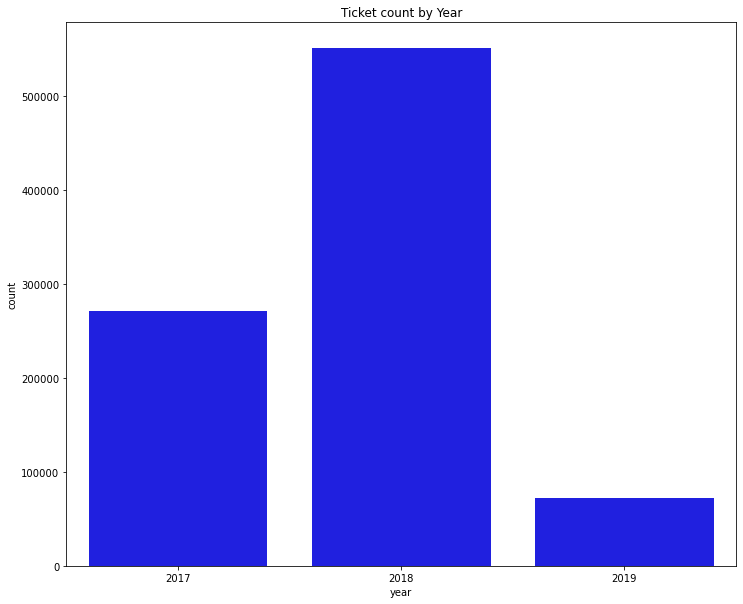

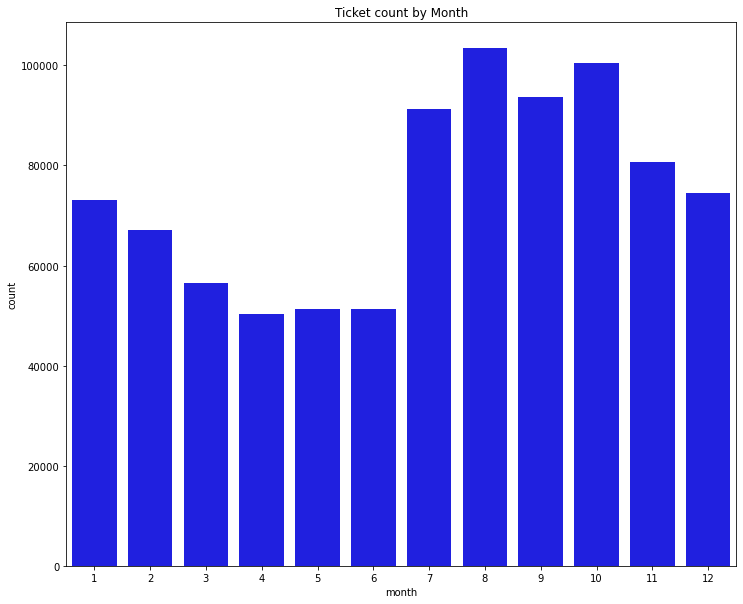

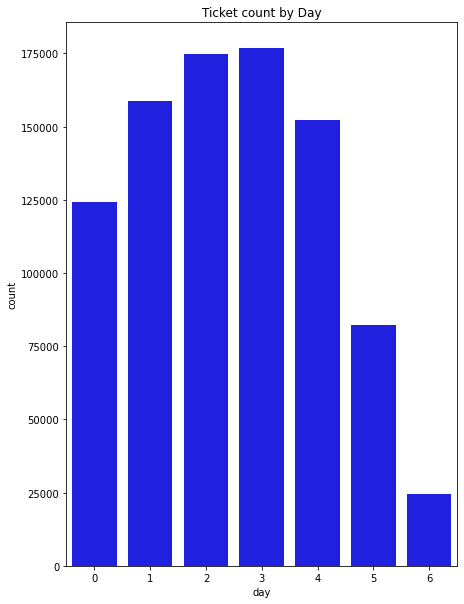

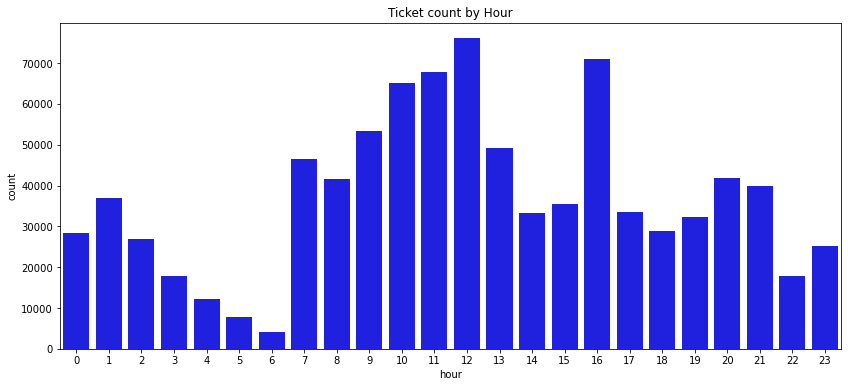

In [106]:
sns.set_palette("pastel")

plt.figure(figsize=(12,10))
sns.countplot(tickets['year'],color='blue')
plt.title('Ticket count by Year')
plt.savefig('Images/Ticket_ct_yr.png')

plt.figure(figsize=(12,10))
sns.countplot(tickets['month'],color='blue')
plt.title('Ticket count by Month')
plt.savefig('Images/Ticket_ct_month.png')

plt.figure(figsize=(7,10))
sns.countplot(tickets['day'],color='blue')
plt.title('Ticket count by Day')
plt.savefig('Images/Ticket_ct_day.png')


plt.figure(figsize=(14,6))
sns.countplot(tickets['hour'],color='blue')
plt.title('Ticket count by Hour')
plt.savefig('Images/Ticket_ct_hour.png');

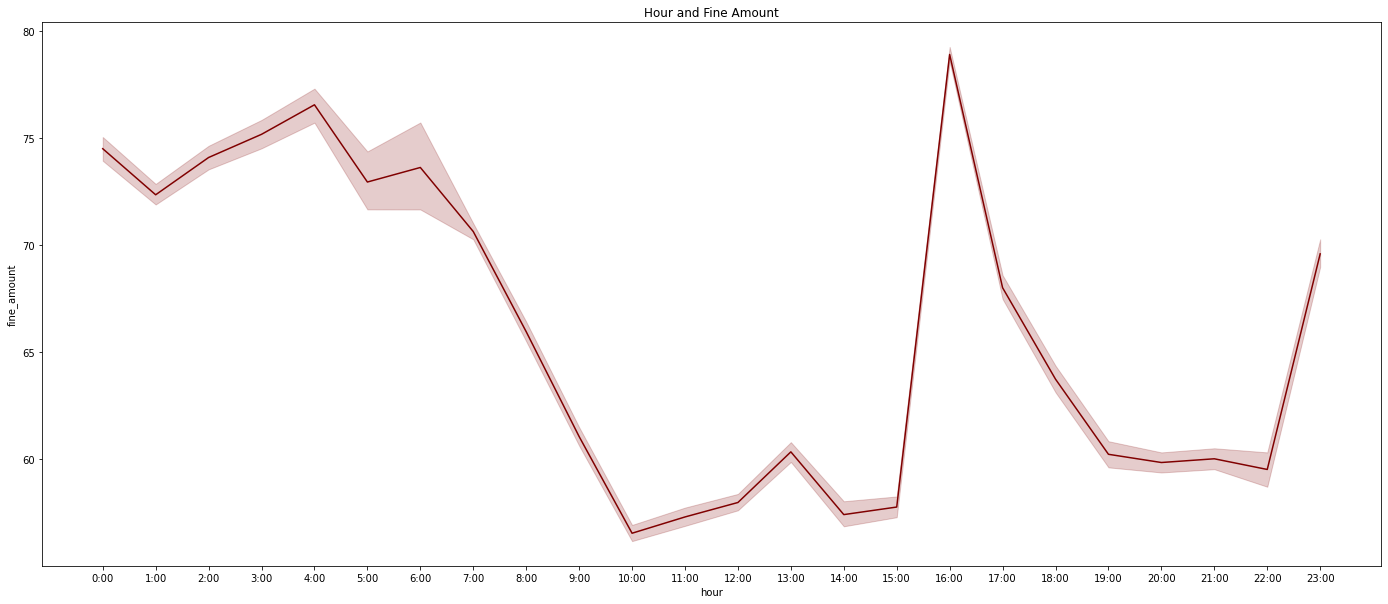

In [108]:
plt.figure(figsize=(24,10))
sns.lineplot(data=tickets, x='hour',y='fine_amount',color='maroon')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
           labels=['0:00','1:00','2:00','3:00','4:00','5:00','6:00','7:00','8:00','9:00',
                  '10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00',
                  '20:00','21:00','22:00','23:00'])
plt.title('Hour and Fine Amount');
plt.savefig('Images/fine_hour.png')

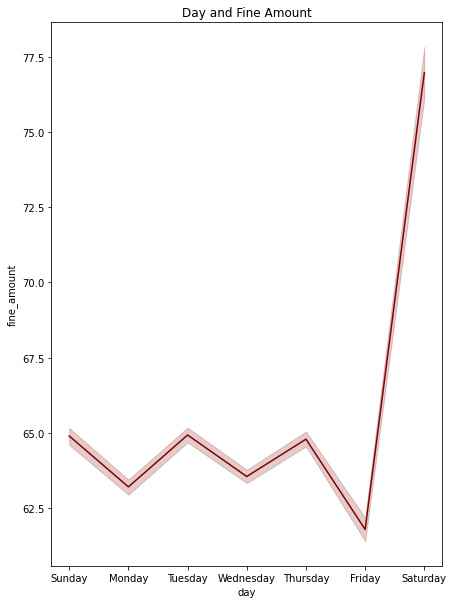

In [109]:
plt.figure(figsize=(7,10))
sns.lineplot(data=tickets, x='day',y='fine_amount',color='maroon')
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['Sunday','Monday','Tuesday','Wednesday',
                                         'Thursday','Friday','Saturday'])
plt.title('Day and Fine Amount');
plt.savefig('Images/fine_day.png')